# Monte Carlo Simulation : GBM model

In [8]:
import sys, subprocess, sqlite3, time
from datetime import datetime, UTC
from pathlib import Path
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [11]:
# --- parameters
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA"]  # change as you like
start = "2015-01-01"       # or set period="5y" and leave start/end=None
end = None
period = None
interval = "1d"
db_path = Path("market_data.db")
table = "prices_raw"

# --- fetch
print(f"[info] fetching {tickers}")
df = yf.download(
    tickers=tickers,
    start=start,
    end=end,
    period=period,
    interval=interval,
    auto_adjust=False,
    group_by="ticker",
    threads=True,
    progress=True,
)

# --- normalize (same logic, unchanged semantics)
def _stack_single(tk, sub):
    sub = sub.copy()
    sub["Ticker"] = tk
    sub.reset_index(inplace=True)
    for col in ["Open","High","Low","Close","Adj Close","Volume"]:
        if col not in sub.columns:
            sub[col] = pd.NA
    return sub[["Date","Ticker","Open","High","Low","Close","Adj Close","Volume"]
               + [c for c in sub.columns if c not in ["Date","Ticker","Open","High","Low","Close","Adj Close","Volume"]]]

if isinstance(df.columns, pd.MultiIndex):
    parts = []
    for tk in sorted({lvl0 for (lvl0, _) in df.columns}):
        parts.append(_stack_single(tk, df[tk]))
    df = pd.concat(parts, ignore_index=True)
else:
    df = _stack_single(tickers[0], df)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.sort_values(["Ticker", "Date"], inplace=True, ignore_index=True)

# --- labels + numerics (no raw drops)
df["Date_ISO"] = df["Date"].dt.strftime("%Y-%m-%d")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

for col in ["Open","High","Low","Close","Adj Close","Volume"]:
    df[f"{col}_num"] = pd.to_numeric(df[col], errors="coerce")

if "Adj Close_num" in df.columns:
    # Future-proof: do not forward-fill by default
    df["DailyReturn_pct"] = df.groupby("Ticker")["Adj Close_num"].pct_change(fill_method=None) * 100.0

df["ETL_InsertedAt"] = datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%S %Z")
df["ETL_Source"] = "yfinance"

# --- SQLite write with WAL + busy timeout + retry to avoid "database is locked"
def write_with_retry(frame: pd.DataFrame, db: Path, table: str, max_retries: int = 5, sleep_sec: float = 1.5):
    attempt = 0
    while True:
        try:
            con = sqlite3.connect(db, timeout=30)  # wait up to 30s for locks
            try:
                cur = con.cursor()
                # WAL improves concurrent reads and reduces write blocking
                cur.execute("PRAGMA journal_mode=WAL;")
                cur.execute("PRAGMA busy_timeout=5000;")  # extra safety
                con.commit()

                frame.to_sql(table, con, if_exists="append", index=False)
                cur.execute(f'CREATE INDEX IF NOT EXISTS idx_{table}_date ON {table}(Date);')
                cur.execute(f'CREATE INDEX IF NOT EXISTS idx_{table}_ticker ON {table}(Ticker);')
                cur.execute(f'CREATE INDEX IF NOT EXISTS idx_{table}_date_ticker ON {table}(Date, Ticker);')
                con.commit()
            finally:
                con.close()
            break
        except sqlite3.OperationalError as e:
            msg = str(e).lower()
            if "database is locked" in msg or "database is busy" in msg:
                attempt += 1
                if attempt > max_retries:
                    raise
                print(f"[warn] database is locked; retrying in {sleep_sec}s (attempt {attempt}/{max_retries})")
                time.sleep(sleep_sec)
                continue
            else:
                raise

write_with_retry(df, db_path, table)

print(f"[done] wrote {len(df):,} rows to {db_path} (table={table})")
df.tail(3)


[info] fetching ['AAPL', 'MSFT', 'GOOGL', 'TSLA']


[*********************100%***********************]  4 of 4 completed


[done] wrote 10,880 rows to market_data.db (table=prices_raw)


Price,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Date_ISO,Year,...,Day,Open_num,High_num,Low_num,Close_num,Adj Close_num,Volume_num,DailyReturn_pct,ETL_InsertedAt,ETL_Source
10877,2025-10-22,TSLA,443.450012,445.540009,429.000000,438.970001,438.970001,84023500,2025-10-22,2025,...,22,443.450012,445.540009,429.000000,438.970001,438.970001,84023500,-0.820155,2025-10-25 13:33:49 UTC,yfinance
10878,2025-10-23,TSLA,420.000000,449.399994,413.899994,448.980011,448.980011,126709800,2025-10-23,2025,...,23,420.000000,449.399994,413.899994,448.980011,448.980011,126709800,2.280340,2025-10-25 13:33:49 UTC,yfinance
10879,2025-10-24,TSLA,446.829987,451.679993,430.170013,433.720001,433.720001,94408400,2025-10-24,2025,...,24,446.829987,451.679993,430.170013,433.720001,433.720001,94408400,-3.398817,2025-10-25 13:33:49 UTC,yfinance


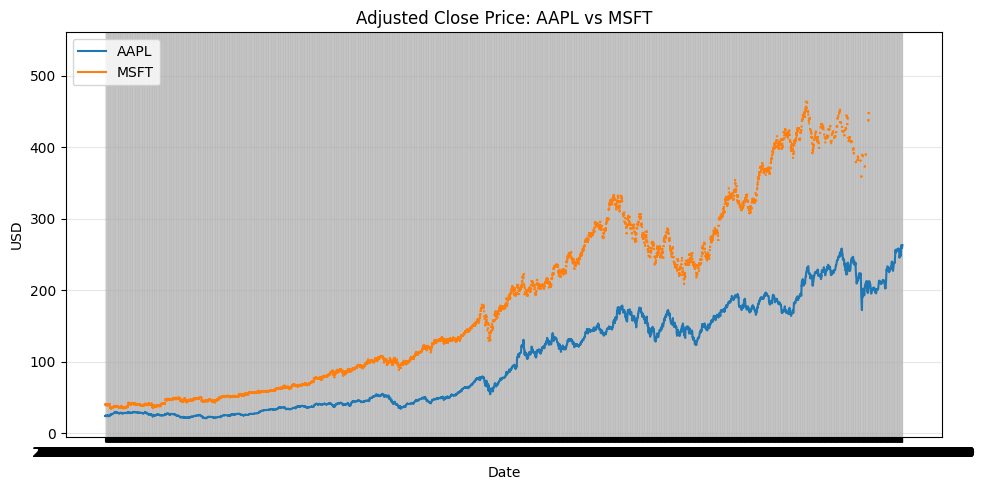

In [12]:
# --- Load data
con = sqlite3.connect("market_data.db")
df = pd.read_sql("""
    SELECT Date, Ticker, [Adj Close_num] AS AdjClose
    FROM prices_raw
    WHERE Ticker IN ('AAPL','MSFT')
    ORDER BY Date;
""", con)
con.close()

# --- Plot both on the same figure
plt.figure(figsize=(10,5))

for tkr, sub in df.groupby("Ticker"):
    plt.plot(sub["Date"], sub["AdjClose"], label=tkr)

plt.title("Adjusted Close Price: AAPL vs MSFT")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


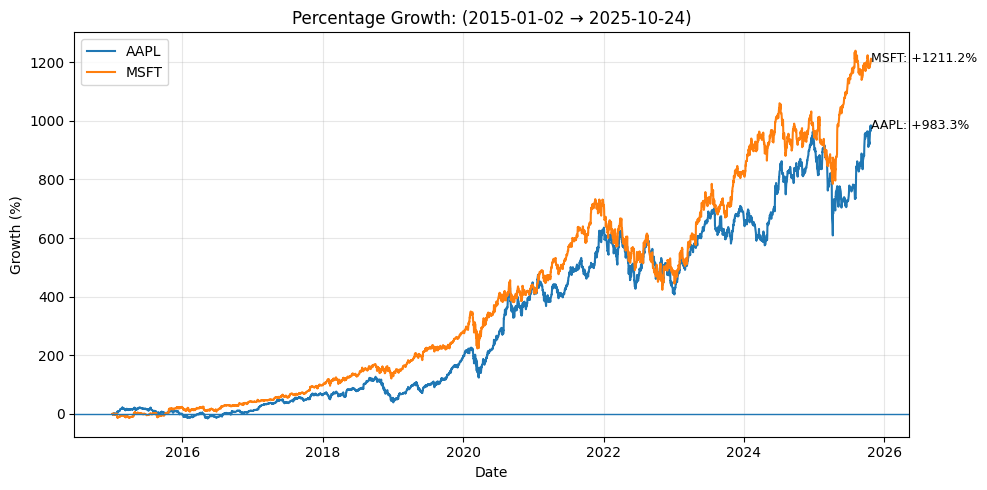

In [19]:
# --- Percentage growth with 1$}

con = sqlite3.connect("market_data.db")
df = pd.read_sql("""
    SELECT Date, Ticker, [Adj Close_num] AS AdjClose
    FROM prices_raw
    WHERE Ticker IN ('AAPL','MSFT')
    ORDER BY Date;
""", con)
con.close()

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

plt.figure(figsize=(10,5))

first_date, last_date = None, None  # placeholders

for tkr, sub in df.groupby("Ticker"):
    sub = sub.dropna(subset=["AdjClose"]).copy()
    if sub.empty:
        print(f"[warn] No valid AdjClose for {tkr}, skipping.")
        continue

    # record first/last valid dates (once)
    if first_date is None:
        first_date = sub["Date"].iloc[0]
    last_date = sub["Date"].iloc[-1]

    base = sub["AdjClose"].iloc[0]
    sub["PctGrowth"] = (sub["AdjClose"] / base - 1.0) * 100.0

    plt.plot(sub["Date"], sub["PctGrowth"], label=tkr)
    end_pct = sub["PctGrowth"].iloc[-1]
    plt.text(sub["Date"].iloc[-1], sub["PctGrowth"].iloc[-1],
             f"{tkr}: {end_pct:+.1f}%", va="center", ha="left", fontsize=9)

# --- dynamic title using date range
if first_date is not None and last_date is not None:
    date_range = f"{first_date:%Y-%m-%d} → {last_date:%Y-%m-%d}"
else:
    date_range = "(dates unknown)"

plt.title(f"Percentage Growth: ({date_range})")
plt.xlabel("Date")
plt.ylabel("Growth (%)")
plt.axhline(0, lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Get daily returns for multiple tickers and pivot
con = sqlite3.connect("market_data.db")
df = pd.read_sql("""
    SELECT Date, Ticker, DailyReturn_pct
    FROM prices_raw
    WHERE Ticker IN ('AAPL','MSFT','GOOGL','TSLA')
    ORDER BY Date;
""", con)
con.close()

pivot = df.pivot(index="Date", columns="Ticker", values="DailyReturn_pct")

# Compute correlation matrix across tickers
corr_matrix = pivot.corr()
print(corr_matrix)


ValueError: Index contains duplicate entries, cannot reshape